# Distance from Coast

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math
import matplotlib.cm as cm
import seaborn as sns
from numpy import savetxt

## Import Coastal Distance File

In [2]:
cd_ds = xr.open_dataset('/home/565/jm1356/Honours/Coastline/coastal_distance_310.nc')

In [3]:
cd_ds

<xarray.Dataset>
Dimensions:   (x: 2450, y: 2050)
Coordinates:
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
  * x         (x) float64 -2.299e+06 -2.297e+06 ... 2.597e+06 2.599e+06
  * y         (y) float64 -1.001e+06 -1.003e+06 ... -5.097e+06 -5.099e+06
Data variables:
    distance  (y, x) float32 ...

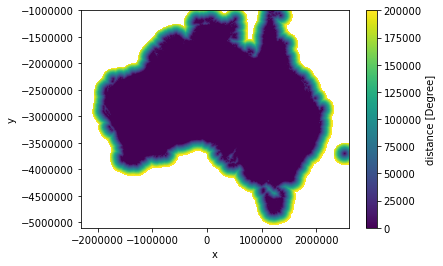

In [4]:
cd_ds.distance.plot()

## Import Inland Distance File

In [5]:
ild_ds = xr.open_dataset('/home/565/jm1356/Honours/Coastline/inland_distance_310.nc')

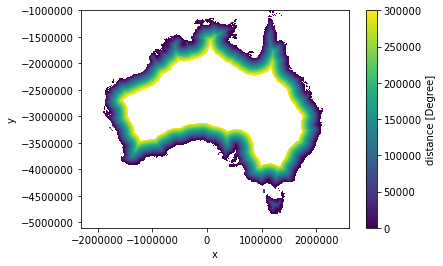

In [6]:
ild_ds.distance.plot()

## Combined File - Distance

In [7]:
dist_ds = xr.where(cd_ds.distance > 0, cd_ds.distance, -ild_ds)

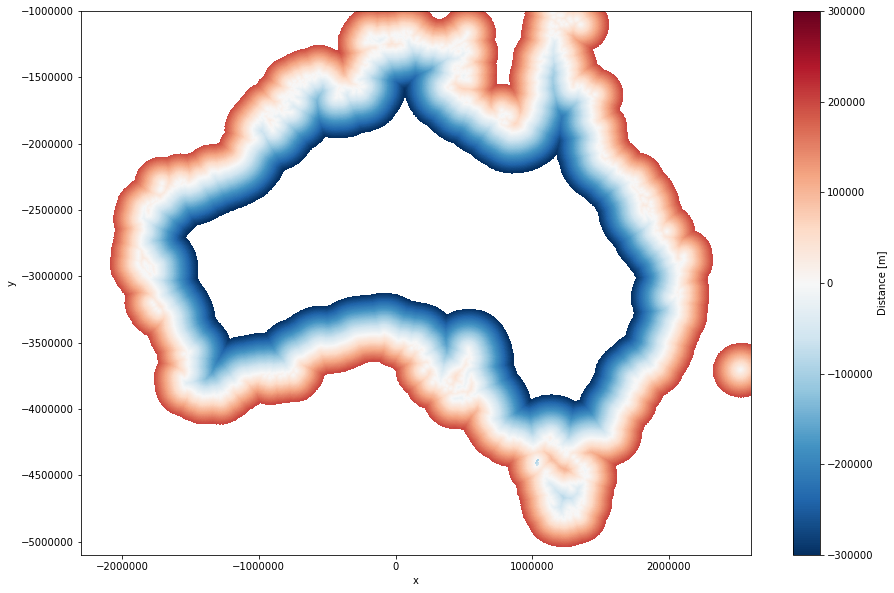

In [17]:
dist_ds.distance.rename('Distance [m]').plot(figsize=(15,10))

In [15]:
dist_ds.distance.rename('Distance [m]')

<xarray.DataArray 'Distance [m]' (y: 2050, x: 2450)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lon      (y, x) float64 111.8 111.9 111.9 111.9 ... 163.4 163.4 163.4 163.4
    lat      (y, x) float64 -7.861 -7.864 -7.867 -7.87 ... -43.74 -43.73 -43.73
  * x        (x) float64 -2.299e+06 -2.297e+06 ... 2.597e+06 2.599e+06
  * y        (y) float64 -1.001e+06 -1.003e+06 ... -5.097e+06 -5.099e+06

## Import Topography Data

In [9]:
dem=xr.open_dataset('/g/data/dt55/wil_outputs/dem_aus.nc')
source_ds=dem.rename_vars({'ASCIITo_asc1':'dem'})

## Cluster

In [10]:
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='/home/565/jm1356/scheduler.json')

In [11]:
client

<Client: 'tcp://10.6.1.72:8729' processes=16 threads=16, memory=68.72 GB>

## Import Filter

## Import Radar Data

In [12]:
startd = "2020-01-01T00:00"
endd = "2020-12-31T23:00"

In [13]:
 df=pd.read_csv('/g/data/dt55/jm1356/data/T15_pix_mean.csv',parse_dates=True)

In [14]:
freq = '10T'
files_date = pd.to_datetime(df.iloc[:,1])
sample_data = '/g/data/dt55/rainfields/prcp-m60/310'
full_list_files = sample_data + files_date.dt.strftime("/%Y/%m/%d/*%Y%m%d_%H%M00*.nc")
###
my_files = []
for fn in full_list_files:
    fn = glob.glob(fn)
    if fn:
        my_files.append(fn[0])

In [15]:
def preprocess_radar(ds):
    if 'valid_time' not in ds.coords:
        ds = ds.assign_coords(
            valid_time=ds.valid_time).expand_dims('valid_time')
    return ds

In [16]:
# open input netcdf
input_radar_ds = xr.open_mfdataset(
    my_files,
    combine='nested',
    concat_dim='valid_time',
    parallel=True,
    lock=False,
    preprocess=preprocess_radar)

In [18]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600, 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
    rainfall_levels_filter = [800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
    rainfall_levels_check = [1800,2000,2200]
    rainfall_levels_2 = [400,800,1200,1600,2000,2400]
    rainfall_levels_hour_acc = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [19]:
radar_data=transform_coords_from_km_to_m(input_radar_ds)

In [21]:
T15_file='/g/data/dt55/pst/projection/PST_tile_T15-Brisbane_projection.nc'
T15_tile_ds=xr.open_dataset(T15_file)

In [23]:
_, T15_fix = xr.align(T15_tile_ds,radar_data,join='left',)

In [24]:
T15_acc_raw=T15_fix.sum(['valid_time'])

In [25]:
T15_acc_fil = xr.where(T15_acc_raw<3000,T15_acc_raw,np.nan)
T15_acc = xr.where(0<T15_acc_fil,T15_acc_raw,np.nan)

In [26]:
target_proj = get_projection_from_dataset(T15_fix)

In [27]:
target_x_points, target_y_points = get_coords_from_dataset(T15_fix)
coord_x_grid_target, coord_y_grid_target = np.meshgrid(target_x_points,
                                                           target_y_points)
proj_info = radar_data.proj.copy()

In [28]:
source_proj = get_projection_from_dataset(source_ds)
target_xyz = source_proj.transform_points(target_proj,
                                              coord_x_grid_target,
                                              coord_y_grid_target,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})
new_x = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})

INFO: Assuming standard PlateCarree projection


In [29]:
topo = source_ds['dem'].interp(lon=new_x,lat=new_y,method='nearest')

In [30]:
T15_topo =  xr.where(topo < 2300 , topo, np.nan)

In [31]:
topo_levels = [0,100,200,300,400,500,600,700,800,900,1000,1200]

## Aligning Distance

In [32]:
_, cd = xr.align(T15_tile_ds,cd_ds,join='left')

In [33]:
_, ild = xr.align(T15_tile_ds,ild_ds,join='left')

In [34]:
_, tdist = xr.align(T15_tile_ds,dist_ds,join='left')

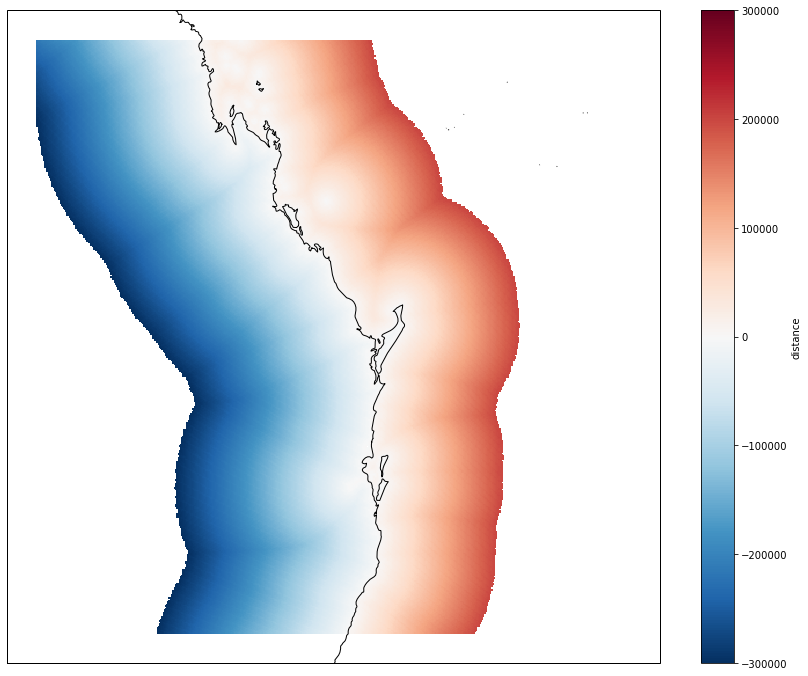

In [35]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
tdist.distance.plot(ax=ax)
ax.coastlines('10m')

## Coastal Distances Only

In [36]:
data = T15_acc_raw.assign(coastal_distance=cd.distance)

In [37]:
prcp_v = data.precipitation.values
dist_v = data.coastal_distance.values

In [38]:
prcp = xr.where(dist_v==np.nan,np.nan,prcp_v)

In [39]:
dist = xr.where(prcp_v==np.nan,np.nan,dist_v)

In [40]:
prcp0 = xr.where(prcp <= 0, np.nan, prcp)

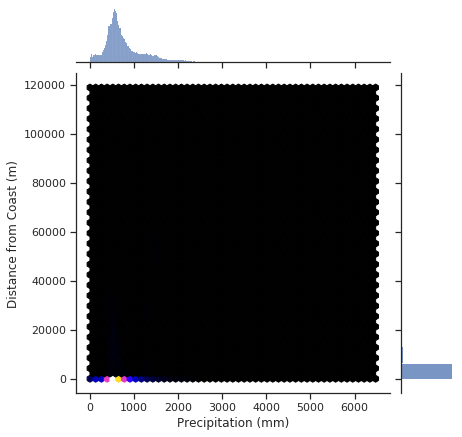

In [90]:
sns.set_theme(style="ticks")

plot = sns.jointplot(x=prcp0.ravel(), y=dist.ravel(), kind="hex", cmap="gnuplot2",dropna=True)

plot.ax_joint.set_title('')
plot.ax_joint.set_ylabel('Distance from Coast (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')

plt.show()

## Inland Distance Only

In [41]:
data = data.assign(inland_distance=ild.distance)

In [42]:
inprcp_v = data.precipitation.values
indist_v = data.inland_distance.values

In [43]:
inprcp = xr.where(indist_v==np.nan,np.nan,inprcp_v)

In [44]:
indist = xr.where(inprcp_v==np.nan,np.nan,indist_v)

In [45]:
inprcp0 = xr.where(inprcp == 0, np.nan, inprcp)

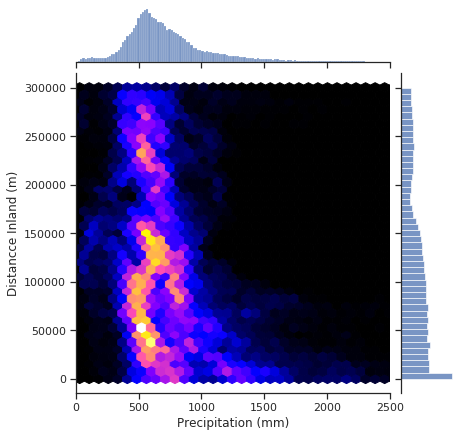

In [96]:
sns.set_theme(style="ticks")

plot = sns.jointplot(x=inprcp0.ravel(), y=indist.ravel(), kind="hex", cmap="gnuplot2",dropna=True, xlim = (0,2500), gridsize = (100,20))

plot.ax_joint.set_title('')
plot.ax_joint.set_ylabel('Distancce Inland (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')

plt.show()

## Combine Arrays

In [46]:
data = T15_acc_raw.assign(total_distance=tdist.distance)

In [47]:
tprcp_v = data.precipitation.values
tdist_v = data.total_distance.values

In [48]:
tprcp = xr.where(tdist_v==np.nan,np.nan,tprcp_v)

In [49]:
tdist = xr.where(tprcp_v==np.nan,np.nan,tdist_v)

In [50]:
tdist120 = xr.where(tdist < -120000, np.nan, tdist)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [51]:
tprcp01 = xr.where(tprcp <= 0, np.nan, tprcp)

In [52]:
tprcp0 = xr.where(tprcp01 > 2500, np.nan, tprcp01)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


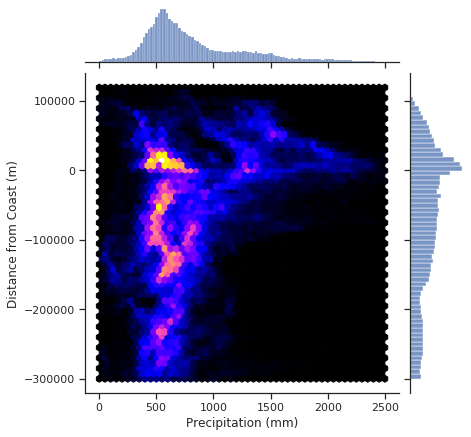

In [53]:
sns.set_theme(style="ticks")

#sns.set(rc={'figure.figsize':(20,20)})

plot = sns.jointplot(x=tprcp0.ravel(), y=tdist.ravel(), kind="hex", cmap="gnuplot2",dropna=True)

plot.ax_joint.set_title('')
plot.ax_joint.set_ylabel('Distance from Coast (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')

plt.show()

## Mean Location

In [54]:
#calculate mean precipitation per elevation bins
distance_bins= np.arange(-300000,120000, 2000)
label_bins= np.arange(-298000,120000, 2000)

In [55]:
mean_precip_per_bin = data.drop(['y_bounds','x_bounds']).groupby_bins("total_distance",distance_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation

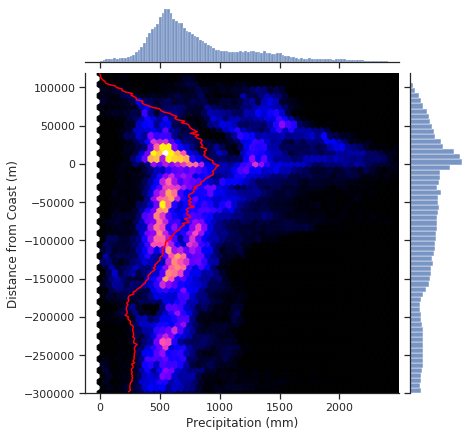

In [57]:
sns.set_theme(style="ticks")

plot = sns.jointplot(x=tprcp0.ravel(), y=tdist.ravel(), kind="hex", cmap="gnuplot2",dropna=True)

plot.ax_joint.set_title('')
plot.ax_joint.set_ylabel('Distance from Coast (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')
plot.ax_joint.plot(mean_precip_per_bin,mean_precip_per_bin.total_distance_bins,color='red')

plt.show()

# Diurnal Cycle

## Grouping into Hours

In [58]:
hour = T15_fix.precipitation.groupby('valid_time.hour').sum()

## Creating Plot

In [1]:
for h in range(24):
    sns.set_theme(style="ticks")

    y = topo.data.ravel()
    x = hour.sel(hour=h).data.ravel()

    plot = sns.jointplot(x=x, y=y, kind="hex", cmap="gnuplot2",dropna=True,xlim=(0,0.5),ylim=(0,1800),gridsize=(200,40),hue_norm=(0,10),bins='log')
    plot.ax_joint.set_ylabel('Elevation (m)')
    plot.ax_joint.set_xlabel('Average Precipitation (mm)')
    #plot.ax_joint.plot(sel_full_hourly_mean_ds_bin.sel(hour=h),sel_full_hourly_mean_ds_bin.sel(hour=h).dem_bins,color='red')
    plot.fig.suptitle('Brisbane Mean for Hour '+str(h))

    plt.show()

NameError: name 'sns' is not defined